In [115]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

import tensorflow as tf


In [116]:
# Read the CSV file
csv_file_path = "C:\\Users\\Suhani\\Desktop\\vscode\\ann\\btm_hourly_2.csv"
df = pd.read_csv(csv_file_path, na_values='None')  # This simplifies the replacement of 'None' with NaN
df = df.apply(pd.to_numeric, errors='coerce')

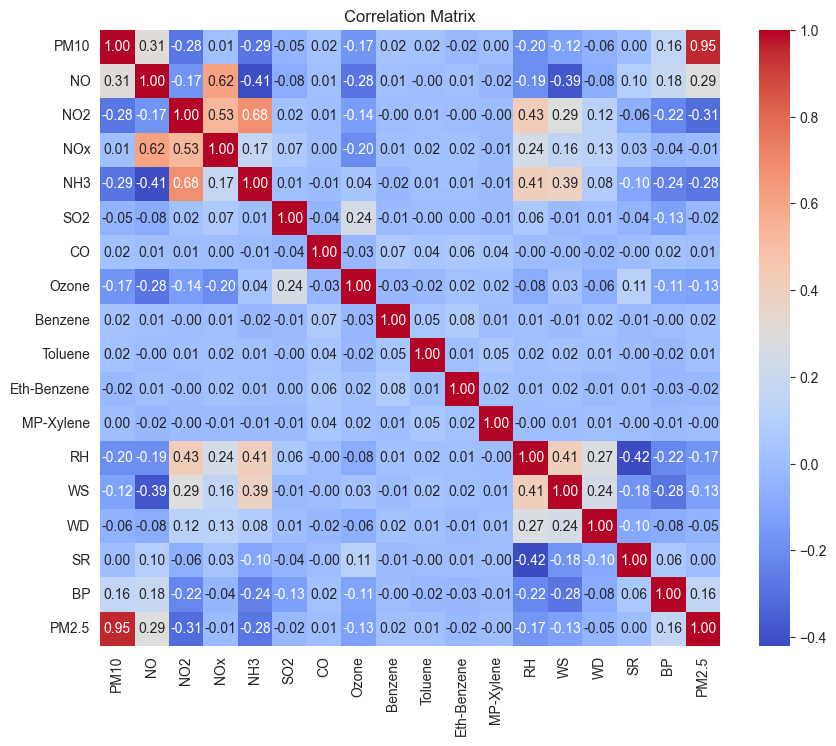

In [117]:
# Set Seaborn style (optional)
sns.set_style("whitegrid")

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [118]:


# Separating features and target variable
X = df.drop('PM2.5', axis=1)  # Features
y = df['PM2.5']  # Target variable

# Impute missing values in features using SimpleImputer
from sklearn.impute import SimpleImputer

# Impute missing values in features
imputer_features = SimpleImputer(strategy='mean')
X_imputed = imputer_features.fit_transform(X)

# Impute missing values in the target variable
imputer_target = SimpleImputer(strategy='mean')
y_imputed = imputer_target.fit_transform(y.values.reshape(-1, 1))

# Convert the NumPy array back to a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
y_imputed = pd.DataFrame(y_imputed, columns=['PM2.5'])

# Calculate Z-scores for each imputed feature
from scipy.stats import zscore
z_scores = zscore(X_imputed)

# Define a threshold for Z-scores to identify outliers
threshold = 3

# Find and remove outliers
outliers = (z_scores > threshold).all(axis=1)
X_no_outliers = X_imputed[~outliers]
y_no_outliers = y_imputed[~outliers]

# Display the first few rows of the DataFrame after handling missing values and outliers
print(pd.DataFrame(X_no_outliers, columns=df.drop('PM2.5', axis=1).columns).head())
print(pd.Series(y_no_outliers.values.flatten()).head())  # Convert y_no_outliers to a flat NumPy array before using head()



    PM10     NO    NO2    NOx    NH3    SO2    CO  Ozone  Benzene  Toluene  \
0  51.35  12.02  15.63  36.59  11.20  14.36  0.74  27.03     0.41     1.43   
1  56.15  12.37  15.70  35.90  11.19  13.82  0.74  27.23     0.43     1.45   
2  46.53  11.68  16.48  36.20  11.37  13.56  0.74  27.98     0.41     1.46   
3  52.02  12.07  15.87  37.06  11.33  12.32  0.74  27.30     0.41     1.44   
4  48.19  11.80  16.07  35.90  11.57  12.73  0.74  27.34     0.41     1.47   

   Eth-Benzene  MP-Xylene     RH        WS          WD     SR      BP  
0         1.68       0.91  82.03  0.868492  228.295308  24.84  775.05  
1         1.69       0.87  87.23  0.868492  228.295308  23.62  775.00  
2         1.65       0.89  89.23  0.868492  228.295308  22.83  775.00  
3         1.71       0.86  89.25  0.868492  228.295308  23.75  775.00  
4         1.69       0.89  89.25  0.868492  228.295308  24.12  775.02  
0    26.16
1    28.46
2    23.87
3    26.49
4    24.66
dtype: float64


In [119]:
# Perform normalization (Feature Scaling)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_no_outliers)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split




In [120]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming X_no_outliers and y_no_outliers are your processed features and target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_no_outliers, test_size=0.2, random_state=42)

# Perform normalization (Feature Scaling)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create and train the MLPRegressor with specified parameters
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(3,3,6,9),
    max_iter=145,
    random_state=42,
    batch_size=100,  # Set your desired batch size
    verbose=True  # Print progress during training
)

mlp_regressor.fit(X_train_normalized, y_train)

# Make predictions on the test set
predictions = mlp_regressor.predict(X_test_normalized)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"R-squared on Test Set: {r2}")


Iteration 1, loss = 244.16233329


c:\Users\Suhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 2, loss = 225.31340266
Iteration 3, loss = 170.07530863
Iteration 4, loss = 143.63261594
Iteration 5, loss = 132.51841966
Iteration 6, loss = 123.16143604
Iteration 7, loss = 112.74926436
Iteration 8, loss = 102.39577517
Iteration 9, loss = 92.79718801
Iteration 10, loss = 82.41620325
Iteration 11, loss = 73.16349433
Iteration 12, loss = 65.45827510
Iteration 13, loss = 58.90533303
Iteration 14, loss = 53.05186472
Iteration 15, loss = 47.94350773
Iteration 16, loss = 43.39513026
Iteration 17, loss = 39.33285865
Iteration 18, loss = 35.64993170
Iteration 19, loss = 32.65594551
Iteration 20, loss = 29.81160105
Iteration 21, loss = 27.41843849
Iteration 22, loss = 25.33436171
Iteration 23, loss = 23.46486952
Iteration 24, loss = 21.78554126
Iteration 25, loss = 20.26433017
Iteration 26, loss = 18.71921911
Iteration 27, loss = 17.31824277
Iteration 28, loss = 16.22462023
Iteration 29, loss = 15.44208486
Iteration 30, loss = 14.84801629
Iteration 31, loss = 14.39086411
Iteration 3

c:\Users\Suhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (145) reached and the optimization hasn't converged yet.
  warnings.warn(


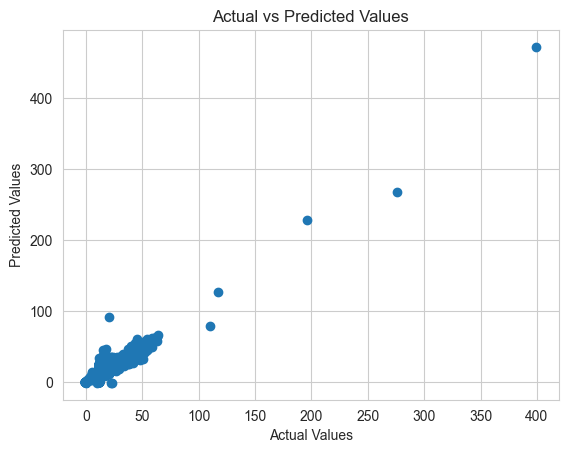

In [121]:
# Assuming 'predictions' contains the predicted values and 'y_test' contains the actual values
predictions = mlp_regressor.predict(X_test)

# Scatter plot for actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
